# Data loading

In [32]:
!pip install pydot
!pip install statsmodels
!pip install plotly


[notice] A new release of pip is available: 24.1.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.1.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.1.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
sns.set(font_scale=1.3, palette='Set2')

import sys
import warnings

warnings.filterwarnings("ignore")
from itertools import product
import matplotlib as mpl

import scipy.stats as scs
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
from scipy.optimize import minimize
from sklearn import metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error as mape
from tqdm.notebook import tqdm
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split

In [3]:
data_path = 'train.csv' 
df = pd.read_csv(data_path)
df

,Store,Date,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment
0,1,2010-01-10,1453329.50,71.89,2.603,211.671989,7.838
1,1,2010-02-04,1594968.28,62.27,2.719,210.820450,7.808
2,1,2010-02-07,1492418.14,80.91,2.669,211.223533,7.787
3,1,2010-02-19,1611968.17,39.93,2.514,211.289143,8.106
4,1,2010-02-26,1409727.59,46.63,2.561,211.319643,8.106
...,...,...,...,...,...,...,...
6250,45,2012-09-14,702238.27,67.87,3.948,191.699850,8.684
6251,45,2012-09-21,723086.20,65.32,4.038,191.856704,8.684
6252,45,2012-09-28,713173.95,64.88,3.997,192.013558,8.684
6253,45,2012-10-02,803657.12,37.00,3.640,189.707605,8.424


In [4]:
df.info()
df.describe()
df.dtypes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6255 entries, 0 to 6254
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6255 non-null   int64  
 1   Date          6255 non-null   object 
 2   Weekly_Sales  6255 non-null   float64
 3   Temperature   6255 non-null   float64
 4   Fuel_Price    6255 non-null   float64
 5   CPI           6255 non-null   float64
 6   Unemployment  6255 non-null   float64
dtypes: float64(5), int64(1), object(1)
memory usage: 342.2+ KB


Store             int64
Date             object
Weekly_Sales    float64
Temperature     float64
Fuel_Price      float64
CPI             float64
Unemployment    float64
dtype: object

# Data analysis


In [5]:
df['Weekly_Sales'].mean(), df['Weekly_Sales'].median()

(1047721.5135107914, 960998.52)

<Axes: >

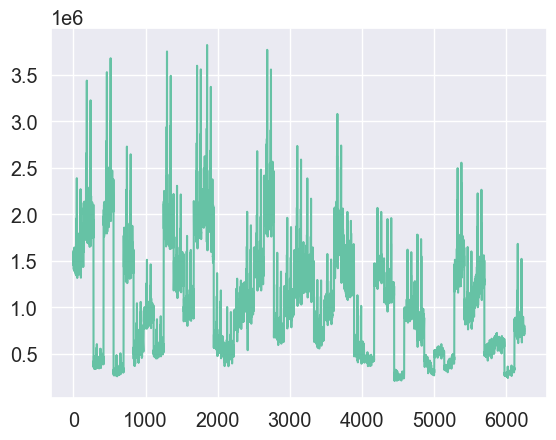

In [6]:
df['Weekly_Sales'].plot()

Видно тут только то, что у каждого магазина свои продажи, поэтому дальше буду брать только один магазин. До этого решения я пришел не сразу, так как забыл просто про этот id магазина.

In [7]:
# Преобразование столбца Date в формат datetime
df['Date'] = pd.to_datetime(df['Date'])

P. S. Я забыл про id магазина потом вообще, непонятно что делал...


Text(0, 0.5, 'Weekly Sales')

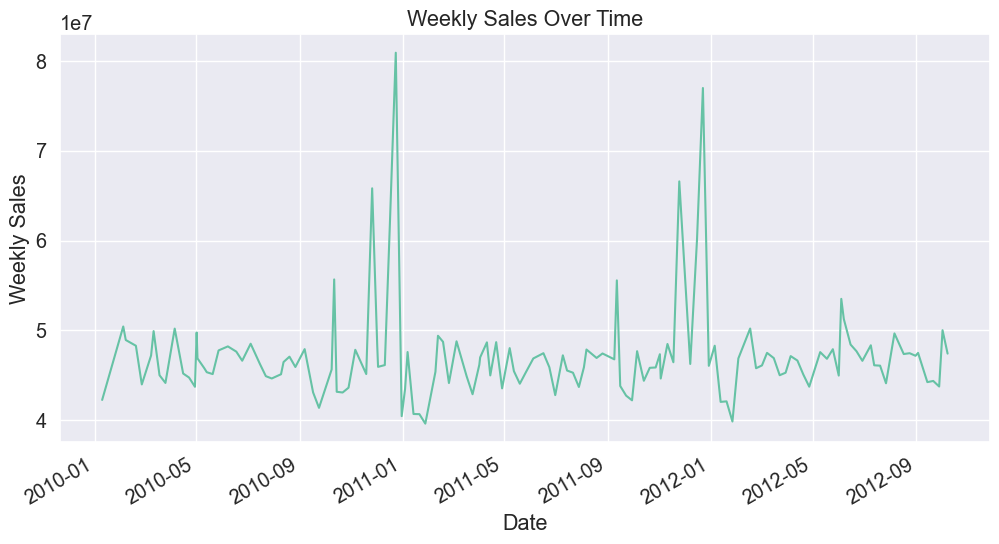

In [8]:
# Группировка по неделям и суммирование продаж
weekly_sales = df.groupby('Date')['Weekly_Sales'].sum()

# Вычисление скользящего среднего
weekly_sales_smoothed = weekly_sales.rolling(window=1, center=True).mean()

# Визуализация
plt.figure(figsize=(12, 6))
weekly_sales_smoothed.plot()
plt.title('Weekly Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')

Тут видно по графику, что некая сезонность имеется с периодичностью 1 год , тренда не вижу, нет стационарности. Судя по графику в некий период перед новым годом прямо зашкаливает количество покупок. В принципе это логично.

Далее будем смотреть на превый магазин, потом уже посмотрим на все остальные

In [9]:
df_id_1 = df[df['Store'] == 1]
df_id_1

,Store,Date,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment
0,1,2010-01-10,1453329.50,71.89,2.603,211.671989,7.838
1,1,2010-02-04,1594968.28,62.27,2.719,210.820450,7.808
2,1,2010-02-07,1492418.14,80.91,2.669,211.223533,7.787
3,1,2010-02-19,1611968.17,39.93,2.514,211.289143,8.106
4,1,2010-02-26,1409727.59,46.63,2.561,211.319643,8.106
...,...,...,...,...,...,...,...
134,1,2012-09-14,1517428.87,74.97,3.717,222.582019,6.908
135,1,2012-09-21,1506126.06,69.87,3.721,222.781839,6.908
136,1,2012-09-28,1437059.26,76.08,3.666,222.981658,6.908
137,1,2012-10-02,1802477.43,48.02,3.409,220.265178,7.348


Text(0, 0.5, 'Weekly Sales')

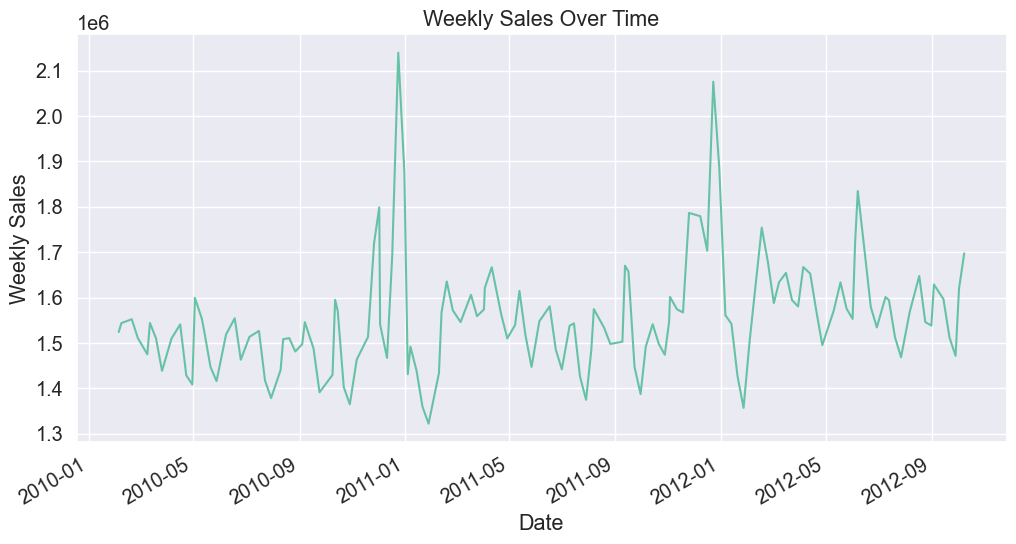

In [10]:
# Группировка по неделям и суммирование продаж
weekly_sales = df_id_1.groupby('Date')['Weekly_Sales'].sum()

# Вычисление скользящего среднего
weekly_sales_smoothed = weekly_sales.rolling(window=2, center=True).mean()

# Визуализация
plt.figure(figsize=(12, 6))
weekly_sales_smoothed.plot()
plt.title('Weekly Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')

In [11]:
def plotMoving(series, rolling_data, n, plot_bounds=False, label="Rolling stat"):
    """
    series - dataframe with timeseries
    n - rolling window size 
    plot_bounds: bool - whether to draw confidence interval
    """
    fig, ax = plt.subplots(figsize=(20, 5))
    plt.title("Moving average\n window size = {}".format(n))
    plt.plot(series.index, rolling_data, "g", label=label)

    if plot_bounds:
        rolling_std = series.rolling(window=n).std()
        upper_bound = rolling_data + 1.96 * rolling_std
        lower_bound = rolling_data - 1.96 * rolling_std
        plt.plot(series.index, upper_bound, "r--", label="Upper Bound / Lower Bound")
        plt.plot(series.index, lower_bound, "r--")
    plt.plot(series.index, series, label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)
    ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MONDAY, interval=2))
    # Устанавливаем интервал отображения дат на оси X
    locator = mdates.DateFormatter('%Y-%m')
    ax.xaxis.set_major_formatter(locator)
    plt.xticks(rotation=45)
    plt.show()

In [12]:
def plotMovingAverage(series, n, plot_bounds=False):
    """
    series - dataframe with timeseries
    n - rolling window size 
    plot_bounds: bool - whether to draw confidence interval
    """
    rolling_data = series.rolling(window=n).mean()
    plotMoving(series, rolling_data, n, label="Rolling average")

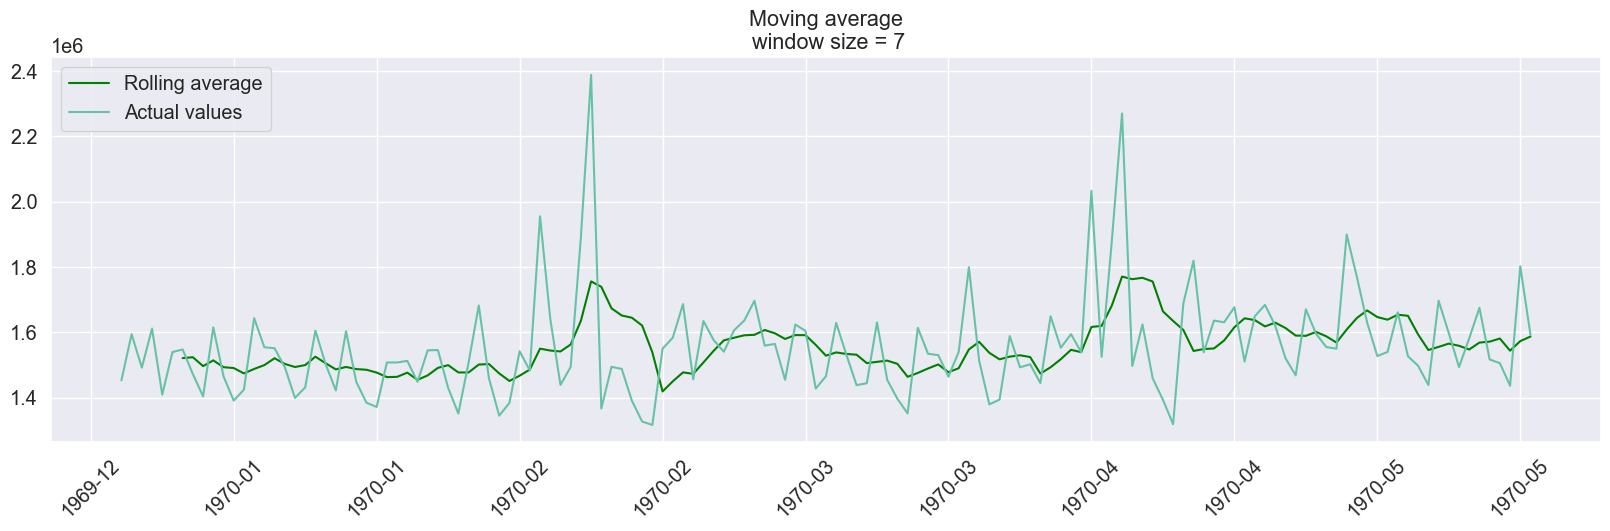

In [13]:
plotMovingAverage(df_id_1['Weekly_Sales'], 7, plot_bounds=True)

Тут можно сказать, что сезонность есть и она аддитивна

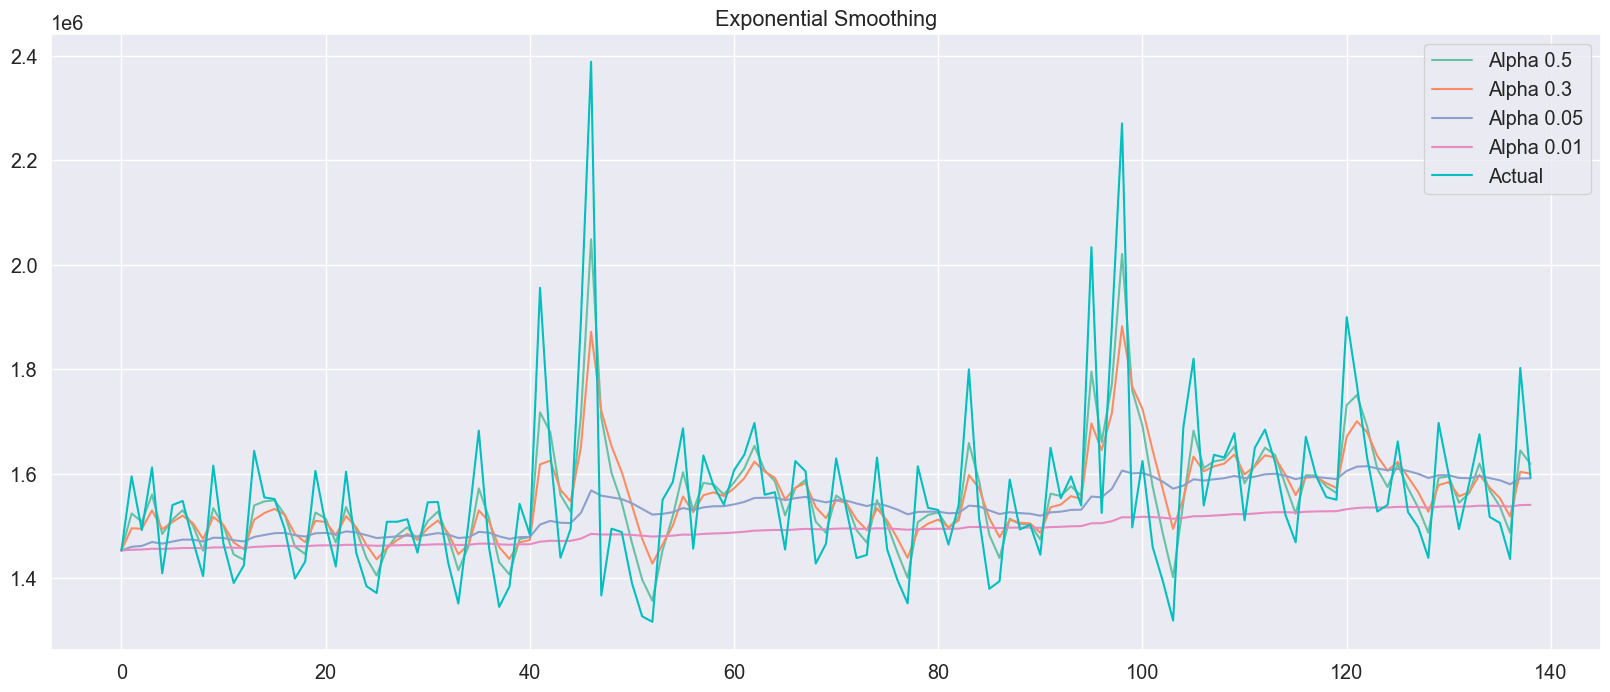

In [14]:
def exponential_smoothing(series, alpha):
    result = [series[0]]  # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n - 1])
    return result

plt.figure(figsize=(20, 8))
for alpha in [0.5, 0.3, 0.05, 0.01]:
    plt.plot(
        exponential_smoothing(df_id_1['Weekly_Sales'], alpha), label="Alpha {}".format(alpha)
    )
plt.plot(df_id_1['Weekly_Sales'].values, "c", label="Actual")
plt.legend(loc="best")
plt.axis("tight")
plt.title("Exponential Smoothing")
plt.grid(True)
plt.show()


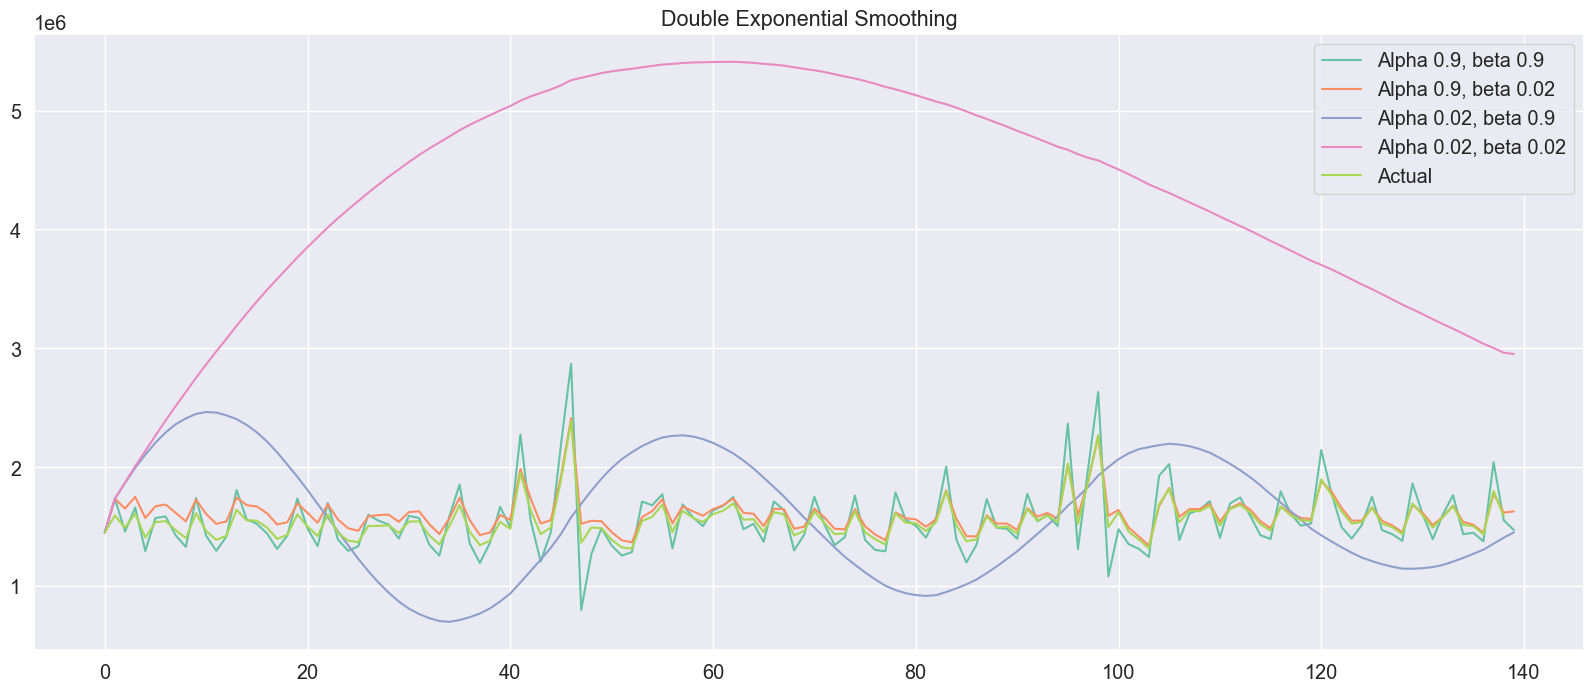

In [15]:
def double_exponential_smoothing(series, alpha, beta):
    result = [series[0]]
    for n in range(1, len(series) + 1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series):  # прогнозируем
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha * value + (1 - alpha) * (level + trend)
        trend = beta * (level - last_level) + (1 - beta) * trend
        result.append(level + trend)
    return result



plt.figure(figsize=(20, 8))
for alpha in [0.9, 0.02]:
    for beta in [0.9, 0.02]:
        plt.plot(
            double_exponential_smoothing(df_id_1['Weekly_Sales'], alpha, beta),
            label="Alpha {}, beta {}".format(alpha, beta),
        )
plt.plot(df_id_1['Weekly_Sales'].values, label="Actual")
plt.legend(loc="best")
plt.axis("tight")
plt.title("Double Exponential Smoothing")
plt.grid(True)
plt.show()

Приступим к модели Хольта-Винтерса

In [16]:
class HoltWinters:

    """
    Модель Хольта-Винтерса с методом Брутлага для детектирования аномалий
    https://fedcsis.org/proceedings/2012/pliks/118.pdf
    
    
    # series - исходный временной ряд
    # slen - длина сезона
    # alpha, beta, gamma - коэффициенты модели Хольта-Винтерса
    # n_preds - горизонт предсказаний
    # scaling_factor - задаёт ширину доверительного интервала по Брутлагу (обычно принимает значения от 2 до 3)
    
    """

    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor

    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series[i + self.slen] - self.series[i]) / self.slen
        return sum / self.slen

    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series) / self.slen)
        # вычисляем сезонные средние
        for j in range(n_seasons):
            season_averages.append(
                sum(self.series[self.slen * j : self.slen * j + self.slen])
                / float(self.slen)
            )
        # вычисляем начальные значения
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += (
                    self.series[self.slen * j + i] - season_averages[j]
                )
            seasonals[i] = sum_of_vals_over_avg / n_seasons
        return seasonals

    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []

        seasonals = self.initial_seasonal_components()

        for i in range(len(self.series) + self.n_preds):
            if i == 0:  # инициализируем значения компонент
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i % self.slen])

                self.PredictedDeviation.append(0)

                self.UpperBond.append(
                    self.result[0] + self.scaling_factor * self.PredictedDeviation[0]
                )

                self.LowerBond.append(
                    self.result[0] - self.scaling_factor * self.PredictedDeviation[0]
                )

                continue
            if i >= len(self.series):  # прогнозируем
                m = i - len(self.series) + 1
                self.result.append((smooth + m * trend) + seasonals[i % self.slen])

                # во время прогноза с каждым шагом увеличиваем неопределенность
                self.PredictedDeviation.append(self.PredictedDeviation[-1] * 1.01)

            else:
                val = self.series[i]
                last_smooth, smooth = (
                    smooth,
                    self.alpha * (val - seasonals[i % self.slen])
                    + (1 - self.alpha) * (smooth + trend),
                )
                trend = self.beta * (smooth - last_smooth) + (1 - self.beta) * trend
                seasonals[i % self.slen] = (
                    self.gamma * (val - smooth)
                    + (1 - self.gamma) * seasonals[i % self.slen]
                )
                self.result.append(smooth + trend + seasonals[i % self.slen])

                # Отклонение рассчитывается в соответствии с алгоритмом Брутлага
                self.PredictedDeviation.append(
                    self.gamma * np.abs(self.series[i] - self.result[i])
                    + (1 - self.gamma) * self.PredictedDeviation[-1]
                )

            self.UpperBond.append(
                self.result[-1] + self.scaling_factor * self.PredictedDeviation[-1]
            )

            self.LowerBond.append(
                self.result[-1] - self.scaling_factor * self.PredictedDeviation[-1]
            )

            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i % self.slen])

In [17]:
from sklearn.model_selection import TimeSeriesSplit


def timeseriesCVscore(x):
    # вектор ошибок
    errors = []

    values = data.values
    alpha, beta, gamma = x

    # задаём число фолдов для кросс-валидации
    tscv = TimeSeriesSplit(n_splits=2)

    # идем по фолдам, на каждом обучаем модель, строим прогноз на отложенной выборке и считаем ошибку
    for train, test in tscv.split(values):

        model = HoltWinters(
            series=values[train],
            slen=13,
            alpha=alpha,
            beta=beta,
            gamma=gamma,
            n_preds=len(test),
        )
        model.triple_exponential_smoothing()

        predictions = model.result[-len(test) :]
        actual = values[test]
        error = mean_squared_error(predictions, actual)
        errors.append(error)
    return np.mean(np.array(errors))

In [18]:
%%time
data = df_id_1['Weekly_Sales'][:-26]  # отложим часть данных для тестирования

# инициализируем значения параметров
x = [0, 0, 0]

# Минимизируем функцию потерь с ограничениями на параметры
opt = minimize(timeseriesCVscore, x0=x, method="TNC", bounds=((0, 1), (0, 1), (0, 1)))

# Из оптимизатора берем оптимальное значение параметров
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

0.024215968555841683 0.10227548587015678 0.004115018461383957
CPU times: total: 328 ms
Wall time: 326 ms


In [19]:
data = df_id_1['Weekly_Sales']
model = HoltWinters(
    data[:-26],
    slen=52,
    alpha=alpha_final,
    beta=beta_final,
    gamma=gamma_final,
    n_preds=26
    ,
    scaling_factor=2.56,
)
model.triple_exponential_smoothing()

In [20]:
def plotHoltWinters():
    Anomalies = np.array([np.nan] * len(data))
    Anomalies[data.values < model.LowerBond] = data.values[
        data.values < model.LowerBond
    ]
    plt.figure(figsize=(25, 10))
    plt.plot(model.result, label="Model")
    plt.plot(model.UpperBond, "r--", alpha=0.5, label="Up/Low confidence")
    plt.plot(model.LowerBond, "r--", alpha=0.5)
    plt.fill_between(
        x=range(0, len(model.result)),
        y1=model.UpperBond,
        y2=model.LowerBond,
        alpha=0.5,
        color="grey",
    )
    plt.plot(data.values, label="Actual")
    plt.plot(Anomalies, "o", markersize=10, label="Anomalies")
    plt.axvspan(len(data) - 13, len(data), alpha=0.5, color="lightgrey")
    plt.grid(True)
    plt.axis("tight")
    plt.legend(loc="best", fontsize=13)
    plt.show()

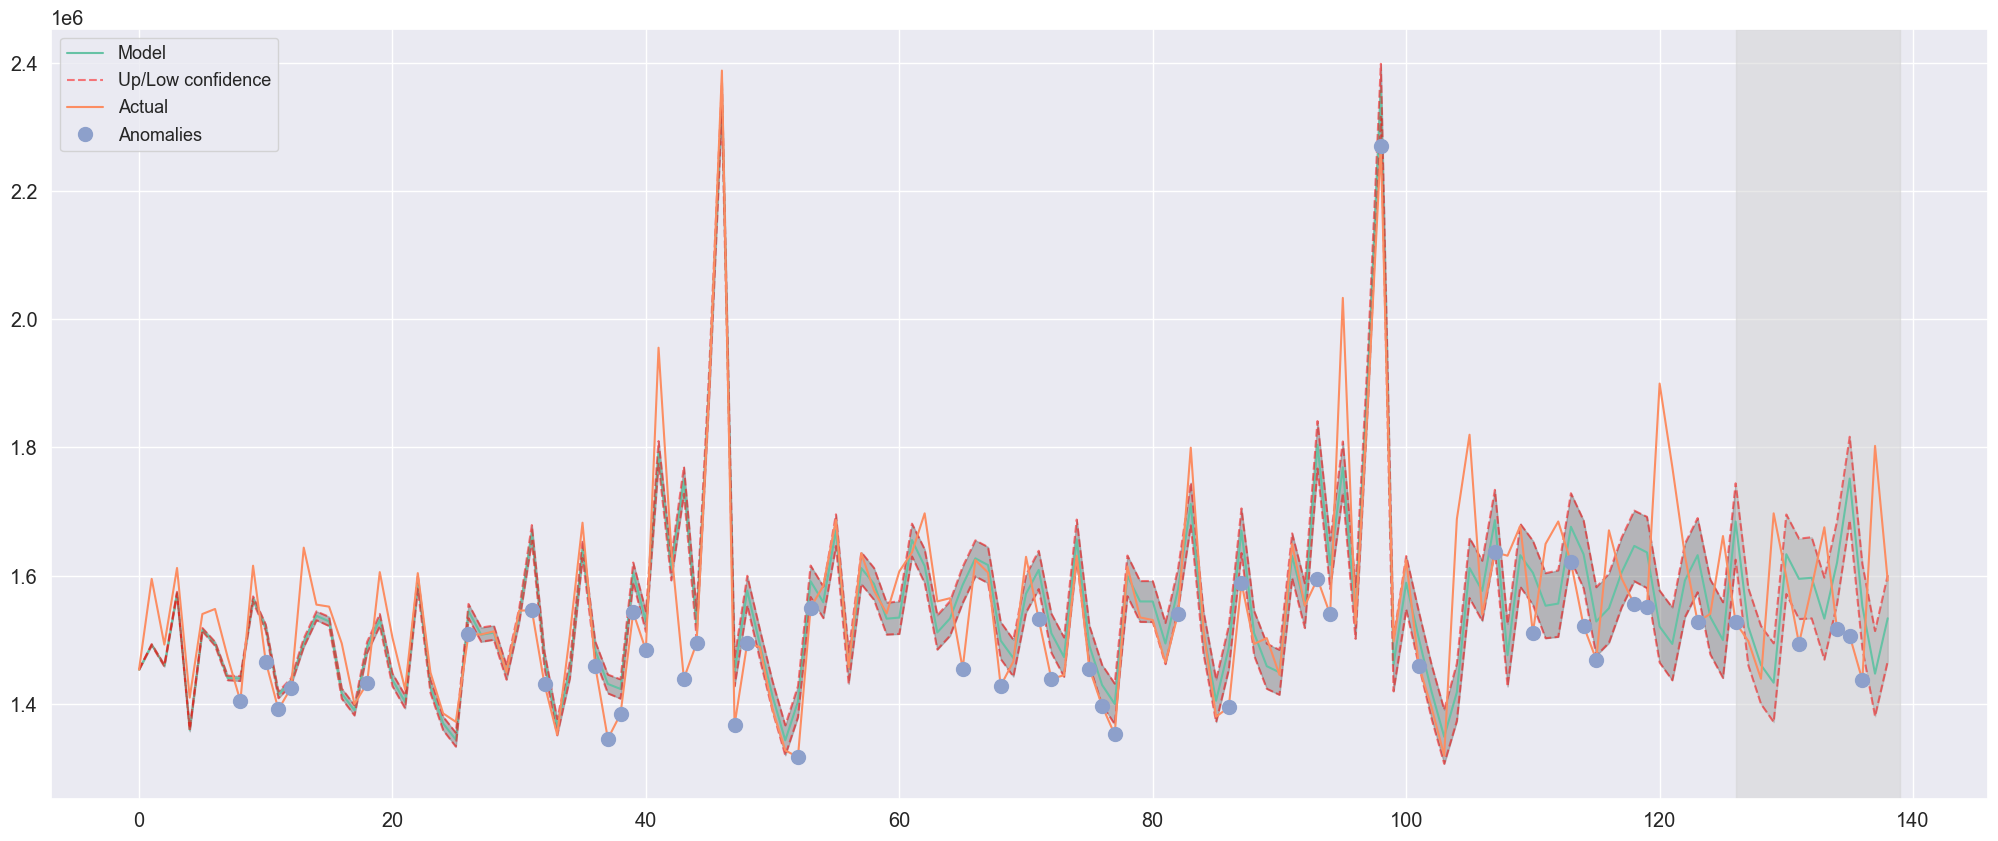

In [21]:
plotHoltWinters()

Прикольный график вышел, проверим ряд на стационарность, а дальше будем уже очищать данные и строить эту модель, только для всех магазинов, так как магазины разные, продажи - тоже.

In [22]:
def tsplot(y, lags=None, figsize=(12, 7), style="bmh"):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        ts_ax.plot(y)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title(
            "Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}".format(p_value)
        )
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()
        plt.show()

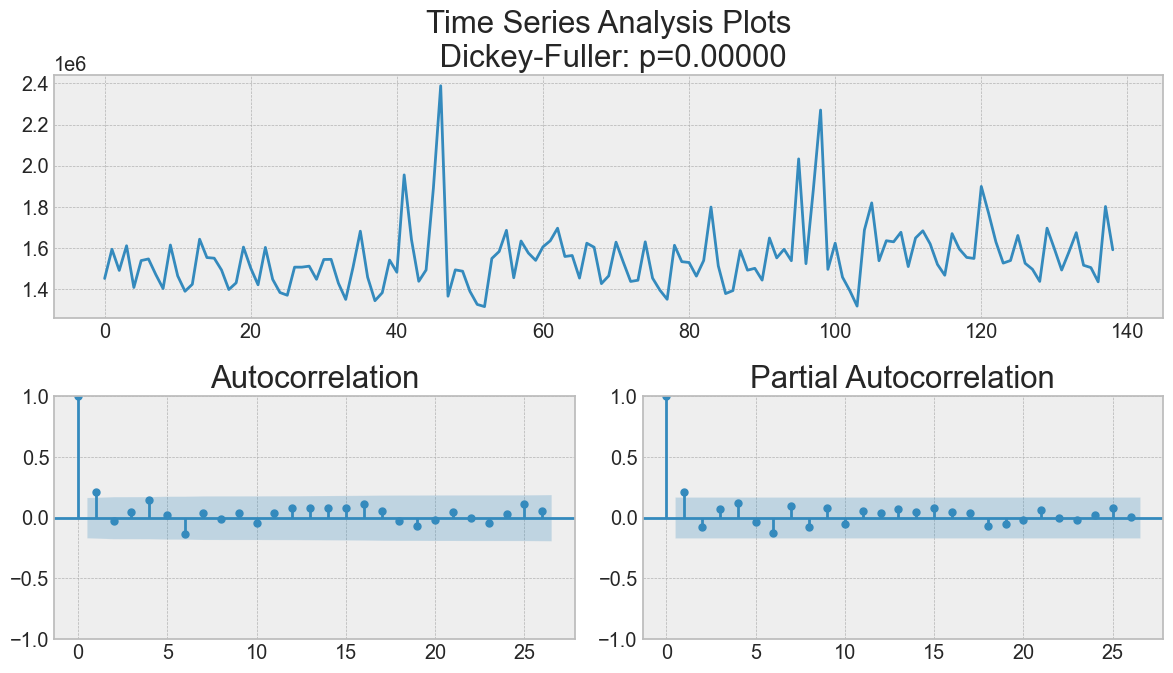

In [23]:
#df_id_2 = df[df['Store'] == 1]
tsplot(df_id_1['Weekly_Sales'], lags=26)

Ряд стационарен оказался

# Подготовка и очистка данных

Так как модель HoltWinters работает только с временным рядом и целевым таргетом, будем использовать ее для начала и выбросим все остальные признаки

In [24]:
df = pd.read_csv(data_path)
#df['Date'] = pd.to_datetime(df['Date'])
df = df.drop(['Temperature', 'Fuel_Price', 'CPI', 'Unemployment'], axis=1)
df.head(-1)

,Store,Date,Weekly_Sales
0,1,2010-01-10,1453329.50
1,1,2010-02-04,1594968.28
2,1,2010-02-07,1492418.14
3,1,2010-02-19,1611968.17
4,1,2010-02-26,1409727.59
...,...,...,...
6249,45,2012-09-03,776968.87
6250,45,2012-09-14,702238.27
6251,45,2012-09-21,723086.20
6252,45,2012-09-28,713173.95


# Train and test models

In [25]:
print(df.dtypes)



Store             int64
Date             object
Weekly_Sales    float64
dtype: object


In [39]:
class HoltWinters:

    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = min(slen, len(self.series))
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor

    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            if self.slen + i >= len(self.series):
                break
            sum += float(self.series[i + self.slen] - self.series[i]) / self.slen
        return sum / self.slen

    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series) / self.slen)
        # вычисляем сезонные средние
        for j in range(n_seasons):
            season_averages.append(
                sum(self.series[self.slen * j : self.slen * j + self.slen])
                / float(self.slen)
            )
        # вычисляем начальные значения
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += (
                    self.series[self.slen * j + i] - season_averages[j]
                )
            if n_seasons != 0: 
                seasonals[i] = sum_of_vals_over_avg / n_seasons
        return seasonals

    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []

        seasonals = self.initial_seasonal_components()

        for i in range(len(self.series) + self.n_preds):
            if i == 0:  # инициализируем значения компонент
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i % self.slen])

                self.PredictedDeviation.append(0)

                self.UpperBond.append(
                    self.result[0] + self.scaling_factor * self.PredictedDeviation[0]
                )

                self.LowerBond.append(
                    self.result[0] - self.scaling_factor * self.PredictedDeviation[0]
                )

                continue
            if i >= len(self.series): 
                m = i - len(self.series) + 1
                self.result.append((smooth + m * trend) + seasonals[i % self.slen])

                self.PredictedDeviation.append(self.PredictedDeviation[-1] * 1.01)

            else:
                val = self.series[i]
                last_smooth, smooth = (
                    smooth,
                    self.alpha * (val - seasonals[i % self.slen])
                    + (1 - self.alpha) * (smooth + trend),
                )
                trend = self.beta * (smooth - last_smooth) + (1 - self.beta) * trend
                seasonals[i % self.slen] = (
                    self.gamma * (val - smooth)
                    + (1 - self.gamma) * seasonals[i % self.slen]
                )
                self.result.append(smooth + trend + seasonals[i % self.slen])

                self.PredictedDeviation.append(
                    self.gamma * np.abs(self.series[i] - self.result[i])
                    + (1 - self.gamma) * self.PredictedDeviation[-1]
                )

            self.UpperBond.append(
                self.result[-1] + self.scaling_factor * self.PredictedDeviation[-1]
            )

            self.LowerBond.append(
                self.result[-1] - self.scaling_factor * self.PredictedDeviation[-1]
            )

            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i % self.slen])

In [40]:
from sklearn.model_selection import TimeSeriesSplit

def timeseriesCVscore(x, data):
    # вектор ошибок
    errors = []
    values = data.values
    alpha, beta, gamma = x

    # задаём число фолдов для кросс-валидации
    tscv = TimeSeriesSplit(n_splits=10)

    # идем по фолдам, на каждом обучаем модель, строим прогноз на отложенной выборке и считаем ошибку
    for train, test in tscv.split(values):

        model = HoltWinters(
            series=values[train],
            slen= 52,
            alpha=alpha,
            beta=beta,
            gamma=gamma,
            n_preds=len(test),
            scaling_factor=2.22
        )
        model.triple_exponential_smoothing()

        predictions = model.result[-len(test) :]
        actual = values[test]
        error = metrics.mean_squared_error(predictions, actual)
        errors.append(error)
    return np.mean(np.array(errors))

Оптимизируем alfa, beta, gamma для функции Хольта-Винтерса.

In [42]:
def HoltWinters_opt(Data):
    data = Data.Weekly_Sales[:-34]
    x = [0, 0, 0]
    opt = minimize(timeseriesCVscore, x0=x, method="TNC", bounds=((0, 1), (0, 1), (0, 1)), args=(data))
    
    alpha_final, beta_final, gamma_final = opt.x
    
    opt_list.append([alpha_final, beta_final, gamma_final])
    
    return pd.Series({
        'Alpha': alpha_final,
        'Beta': beta_final,
        'Gamma': gamma_final
    })

Применим эти параметры так, чтобы они высчитывались для каждого магазина отдельно, а то в этом не будет смысла

In [94]:
opt_df = df.groupby(by='Store')[['Weekly_Sales']].apply(func=HoltWinters_opt)

In [95]:
opt_df

,Alpha,Beta,Gamma
Store,,,
1,0.008052,0.510166,0.000000
2,0.110554,0.018104,0.000000
3,0.026316,0.030999,0.000000
4,0.009080,0.324756,0.330719
5,0.043016,0.073505,0.201951
6,0.256519,0.004620,0.000000
7,0.016826,0.170651,0.148232
8,0.025202,0.159016,0.083355
9,0.014320,0.176645,0.289219


Получили наши коээффициенты, теперь можно строить предсказание на 4 недели.

In [114]:
predictions = []
store_id = 0
for alpha, beta, gamma in opt_df.values:
    store_id+=1
    data = df[df['Store'] == store_id]['Weekly_Sales'].reset_index(drop=True)
    
    model = HoltWinters(
        data,
        slen=52,
        alpha=alpha,
        beta=beta,
        gamma=gamma,
        n_preds=4,
        scaling_factor=2.33,
    )
    model.triple_exponential_smoothing()

    predictions.append(model.result[-4])
    predictions.append(model.result[-3])
    predictions.append(model.result[-2])
    predictions.append(model.result[-1])
    

# SUbmit

In [111]:
data = {
        "Weekly_Sales": predictions
}
submit = pd.DataFrame(data)
submit.to_csv('submission.csv', index_label="ID")

with open('output.csv', 'w') as file:
    for predict in predictions:
        file.write(str(predict) + '\n')

Дальше идут пережитки прошлого, смотреть их не нужно

In [146]:
def predict(data_path, lr, lag_start=4, lag_end=20):
    data = pd.read_csv(data_path)
    data['Date'] = pd.to_datetime(data['Date'])
    data['year'] = data['Date'].dt.year
    data['quarter'] = data['Date'].dt.quarter
    data['month'] = data['Date'].dt.month
    data = data.drop("Date", axis=1)

    data.columns = ["Store", "Temperature", "Fuel_Price", "CPI", "Unemployment", "year", "quarter", "month"]

    max_lag = min(lag_end, len(data))

    # Добавляем лаги исходного ряда в качестве признаков
    for i in range(lag_start, max_lag):
        data[f"lag_{i}"] = data['Store'].shift(i)

    # Выкидываем строки с пропусками
    data = data.dropna()
    data = data.reset_index(drop=True)

    # Выбираем только те признаки, которые были использованы при обучении модели
    X_test = data[list(lr.feature_names_in_)]

    predictions = lr.predict(X_test)

    data = {
        "Weekly_Sales": predictions
    }
    submit = pd.DataFrame(data)
    submit.to_csv('submission.csv', index_label="ID")

    with open('output.csv', 'w') as file:
        for predict in predictions:
            file.write(str(predict) + '\n')

    return predictions

Эта старая версия программы, где данные терялись, поэтому не срослось, да и результаты странные, продажи не могут быть отрицательными...

In [147]:
predict('test.csv', lr)

array([195161.88835646,  61460.24931209,  53125.2056911 , 126401.49826202,
       193042.36664088,  84406.84080616,  79829.75093476, 150522.91402885,
       214564.57950167,  60642.64195707,  52881.15192676, 126932.28605939,
       194563.23708649,  56058.05266409,  48447.82902317, 121481.39225073,
       189953.45237993, 159157.47358315, 149344.10627611, 197535.60002607,
       286872.87958376,  37573.58947638,  30606.24617712, 103591.3150114 ,
       168891.14376202, 127663.26766889, 118165.03800447, 154055.67131393,
       255529.93973796, 124935.28547153, 126152.11803749, 185437.50992043,
       252600.57001799,  67656.91405891,  59599.86358736, 124525.1338117 ,
       199607.35771461, 121273.31395765, 113344.99081218, 176295.88818076,
       254437.98381028,  75852.79015964,  70721.05803719, 139119.0966724 ,
       203331.85889268, 117087.63307139, 120277.22728032, 176050.67963462,
       248774.073938  ,  99761.23501736,  90956.92941488, 156421.98341867,
       230871.60819815, 1